In [54]:
import numpy as np
from tqdm import tqdm

from system import (
    states,
    s_state,
    t_state, 
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
    rows,
    cols
)
from model import Model
from policy import Policy, PolicyInit, ch_egreedy
from agent import Agent

In [55]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [56]:
def Egreedy_geneps(T: int, eps, Q_val: np.ndarray, start_state: np.ndarray, model: Model):
        estate = [start_state]
        start_action = ch_egreedy(eps, Q_val, start_state)
        eaction = [start_action]
        ereward = [
            model.get_reward(
                start_state, model.gen_next(start_state, start_action)
            )
        ]
        for i in range(T):
            estate.append(model.gen_next(estate[-1], eaction[-1], astuple=True))
            eaction.append(ch_egreedy(eps, Q_val, estate[-1]))
            ereward.append(model.get_reward(estate[-2], estate[-1]))
            if ereward[-1] == model.get_reward(estate[-2], t_state):
                break
        return estate, eaction, ereward

In [57]:
Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
Q_val[to_idx(t_state)][:] = 0
episodic_reward = []
Qvconvergence = []

Ts = 100
gamma = 0.95
alpha = 0.08
epsilon = 0.3
lambda_ = 0.2
for i in tqdm(range(1000)):
    state = s_state 
    tr = 0
    while True:
        estates, eactions, erewards = Egreedy_geneps(Ts, epsilon, Q_val, state, model)
        T = len(erewards)
        tr += erewards[0]
        sr = 0
        sv = 0
        g = 0
        pwl = lambda_
        for j in range(1, T):
            s = estates[T - j - 1]
            a = eactions[T - j - 1]
            r = erewards[T - j - 1]
            ns = estates[T - j]
            na = eactions[T - j]
            sr = sr * lambda_ + r*(1 - pwl)
            sv = sv * gamma * lambda_ + Q_val[to_idx(ns)][na]
            g = sr + gamma*(1 - lambda_)*sv
            Q_val[to_idx(s)][a] = Q_val[to_idx(s)][a] + alpha * (g - Q_val[to_idx(s)][a])
            pwl = pwl * lambda_

        
        state = estates[1]
        if (state == t_state).all():
            break
    # episodic_reward.append(np.max(Q_val[to_idx(s_state)][get_valid_actions(s_state)]))
    Qvconvergence.append(Q_val[to_idx(s_state)][7])
    episodic_reward.append(tr)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:51<00:00, 19.34it/s]


In [58]:
valf = []
for s in states:
    valid_actions = get_valid_actions(s)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

for s in states: 
    valid_actions = get_valid_actions(s)
    action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
    policy.set_action(s, action)
agent.change_policy(policy)

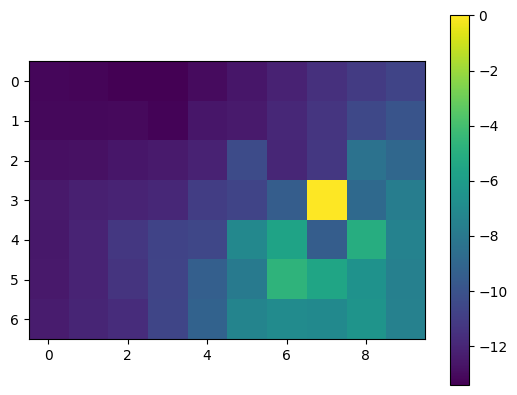

In [59]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

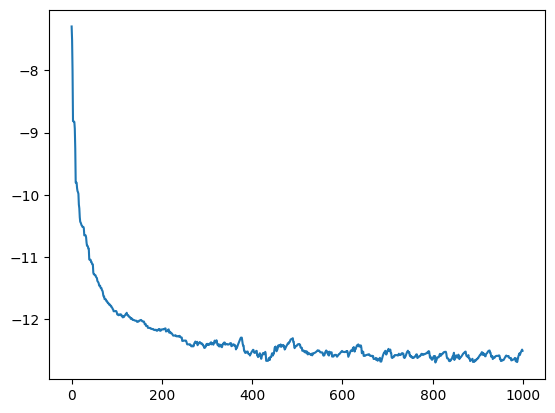

In [60]:
Qvconvergence = np.array(Qvconvergence)
plt.plot(Qvconvergence)

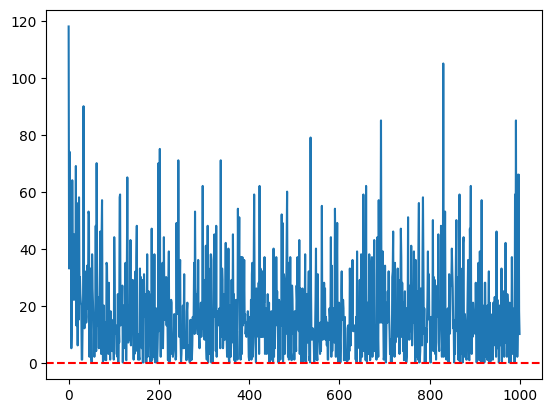

In [61]:
ecreward = np.load('OptimalValueFunction.npy')
episodic_regret = np.abs(episodic_reward - ecreward[to_idx(s_state)])
plt.plot(episodic_regret)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

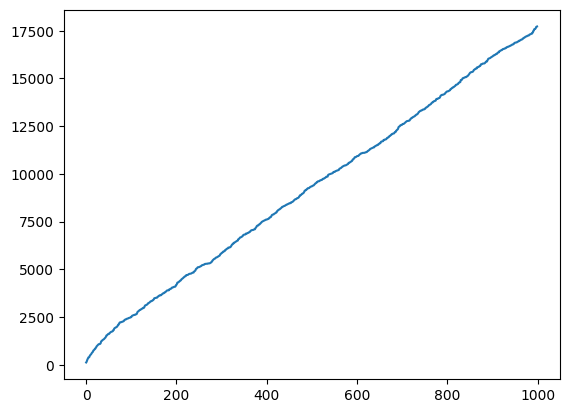

In [62]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)
plt.show()

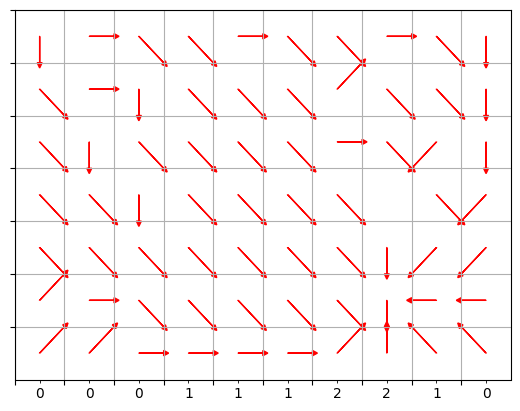

In [63]:
ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

# ## plot 8 types arrows in each grid cell corresponding to the action in the optimal policy
# 0: up-left, 1:up, 2: up-right, 3: left,4: right,5:down-left,6:down,7:down-right
for i in range(rows):
    for j in range(cols):
        s = np.array([i, j])
        if i == t_state[0] and j == t_state[1]:
            continue
        action = policy.get_action(s)
        x_start = j + 0.5  # x-coordinate shifted to the middle of the grid cell
        y_start = i + 0.5  # y-coordinate shifted to the middle of the grid cell
        
        if action == 0:
            plt.arrow(x_start, y_start, -0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 1:
            plt.arrow(x_start, y_start, 0, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 2:
            plt.arrow(x_start, y_start, 0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 3:
            plt.arrow(x_start, y_start, -0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 4:
            plt.arrow(x_start, y_start, 0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 5:
            plt.arrow(x_start, y_start, -0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 6:
            plt.arrow(x_start, y_start, 0, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 7:
            plt.arrow(x_start, y_start, 0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')


In [86]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [6 3], Reward: -1
State: [6 3], Action: [0 1], Next State: [6 4], Reward: -1
State: [6 4], Action: [0 1], Next State: [6 5], Reward: -1
State: [6 5], Action: [0 1], Next State: [6 6], Reward: -1
State: [6 6], Action: [-1  1], Next State: [3 7], Reward: 0
Game Over - Score: -6


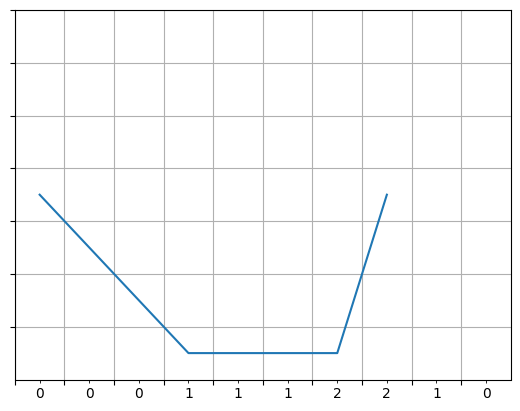

In [87]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()